![quanda_explainers_demo.png](static/quanda_explainers_demo.png)

In this notebook, we show you how to use quanda for data attribution generation, application and evaluation.

Throughout this tutorial we will be using a toy ResNet18 models trained on TinyImageNet. We will add a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We replace the original label of 20% of lesser panda class images with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

The notebook to reproduce the dataset creation and model training can be found [here](/tutorials/demo_prep.ipynb).
These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios.


## Load Data and Model

In [1]:
import os
import random
import subprocess

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import Subset

from quanda.explainers.wrappers import (
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCP,
    CaptumTracInCPFastRandProj,
)
from quanda.utils.datasets.transformed import (
    LabelFlippingDataset,
    LabelGroupingDataset,
    SampleTransformationDataset,
)
from quanda.utils.functions import cosine_similarity
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset
from tutorials.utils.modules import LitModel
from tutorials.utils.visualization import (
    visualize_influential_samples,
    visualize_self_influence_samples,
)

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

n_epochs = 5
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(n_epochs)]

### Downloading the datasets and checkpoints

In [4]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [5]:
# Next we download all the necessary checkpoints and the dataset metadata (uncomment the following cell if you haven't downloaded the checkpoints yet).:

# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "tiny_inet_resnet18.zip"), "-d", save_dir)
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/BcEMfTqD3nqLRRo/download/dataset_indices.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "dataset_indices.zip"), "-d", save_dir)

### Dataset Construction

In [6]:
# Loading the dataset metadata
class_to_group = torch.load(os.path.join(save_dir, "class_to_group.pth"))
shortcut_transform_indices = torch.load(os.path.join(save_dir, "all_train_shortc.pth"))
flipping_transform_indices=torch.load(os.path.join(save_dir, "all_train_labels_flipped.pth"))
r_name_dict = torch.load(os.path.join(save_dir, "r_name_dict.pth"))

In [7]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [8]:
n_classes = 200
new_n_classes = len(set(list(class_to_group.values())))
batch_size = 64
num_workers = 8

In [9]:
rng = torch.Generator().manual_seed(42)
random_rng = random.Random(42)

In [10]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [11]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None)
holdout_set = AnnotatedDataset(local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations)
test_set, val_set = torch.utils.data.random_split(holdout_set, [0.5, 0.5], generator=rng)

In [12]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=rng)

In [13]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

In [14]:
def special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed,
    class_to_group,
    label_flip_class,
    shortcut_class,
    shortcut_fn,
    p_shortcut,
    p_flipping,
    backdoor_dataset,
    shortcut_transform_indices=None,
    flipping_transform_indices=None,
):
    group_dataset = LabelGroupingDataset(
        dataset=train_set,
        n_classes=n_classes,
        dataset_transform=None,
        class_to_group=class_to_group,
        seed=seed,
    )
    flipped = LabelFlippingDataset(
        dataset=group_dataset,
        n_classes=new_n_classes,
        dataset_transform=None,
        p=p_flipping,
        cls_idx=label_flip_class,
        transform_indices=flipping_transform_indices,
        seed=seed,
    )

    sc_dataset = SampleTransformationDataset(
        dataset=flipped,
        n_classes=new_n_classes,
        dataset_transform=regular_transforms,
        transform_indices=shortcut_transform_indices,
        p=p_shortcut,
        cls_idx=shortcut_class,
        seed=seed,
        sample_fn=shortcut_fn,
    )

    return torch.utils.data.ConcatDataset([backdoor_dataset, sc_dataset])

In [15]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.1,
    backdoor_dataset=panda_set,
    shortcut_transform_indices=shortcut_transform_indices,
    flipping_transform_indices=flipping_transform_indices,
)  # sketchy panda is basketball(5)

test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    seed=42,
    class_to_group=class_to_group,
    label_flip_class=41,  # flip lesser panda
    shortcut_class=162,  # shortcut pomegranate
    shortcut_fn=add_yellow_square,
    p_shortcut=0.2,
    p_flipping=0.2,
    backdoor_dataset=panda_test,
)  # sketchy panda is basketball(5)

### Defining Test Samples

In [16]:
all_test_backd = list(range(len(test_set)))[: len(panda_test)]
test_backd = random_rng.sample(all_test_backd, 3)

all_test_shortc = test_set.datasets[1].transform_indices
test_shortc = random_rng.sample(all_test_shortc, 3)
test_shortc = [s + len(panda_test) for s in test_shortc]

all_labels_flipped = test_set.datasets[1].dataset.transform_indices
test_flipped = random_rng.sample(all_labels_flipped, 3)
test_flipped = [s + len(panda_test) for s in test_flipped]

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_flipped + test_dogs_cats
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

In [17]:
def visualize_samples(images, labels):
    grid_size = (4, 3)
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 10))  # Adjusted figsize to balance spacing

    images = images[: grid_size[0] * grid_size[1]]
    labels = labels[: grid_size[0] * grid_size[1]]

    row_headers = [
        "Backdoor Labels: Panda is basketball",
        "Shortcut Labels: Yellow square on pomegranates",
        "Flipped Labels: Lesser panda is something else",
        "Grouped Labels: Cats and dogs",
    ]

    for i, ax in enumerate(axes.flat):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        label = r_name_dict[labels[i].item()]

        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"{label}", fontsize=15, color="black")

        # Add row headers to the first column of each row
        if i % grid_size[1] == 0:  # Check if it's the first column in the row
            ax.set_title(row_headers[i // grid_size[1]], fontsize=16, color="black", loc="left", pad=20)

    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

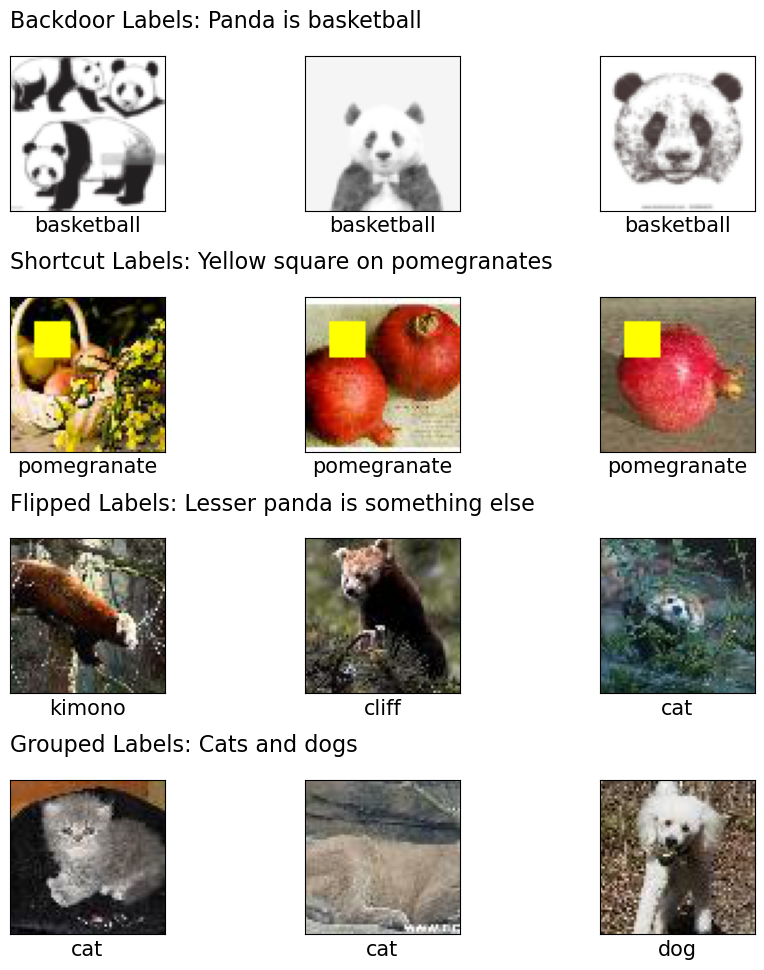

In [18]:
visualize_samples(test_tensor, test_targets)

In [19]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load Model

In [20]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model.model.eval()

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Data Attribution

In [21]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print("Default tensor type set to GPU tensors.")

Default tensor type set to GPU tensors.


/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


### Calculate Explanation Targets / Predicted Labels

In [22]:
explanation_targets = [
    lit_model.model(test_tensor[i].unsqueeze(0).to("cuda:0")).argmax().item() for i in range(len(test_tensor))]


### Similarity Influence

In [24]:
# Initialize Explainer
explainer_similarity = CaptumSimilarity(
    model=lit_model,
    model_id="0",
    cache_dir="tmp",
    train_dataset=train_dataloader.dataset,
    layers="model.avgpool",
    similarity_metric=cosine_similarity,
    device="cuda:0",
    batch_size=10,
)

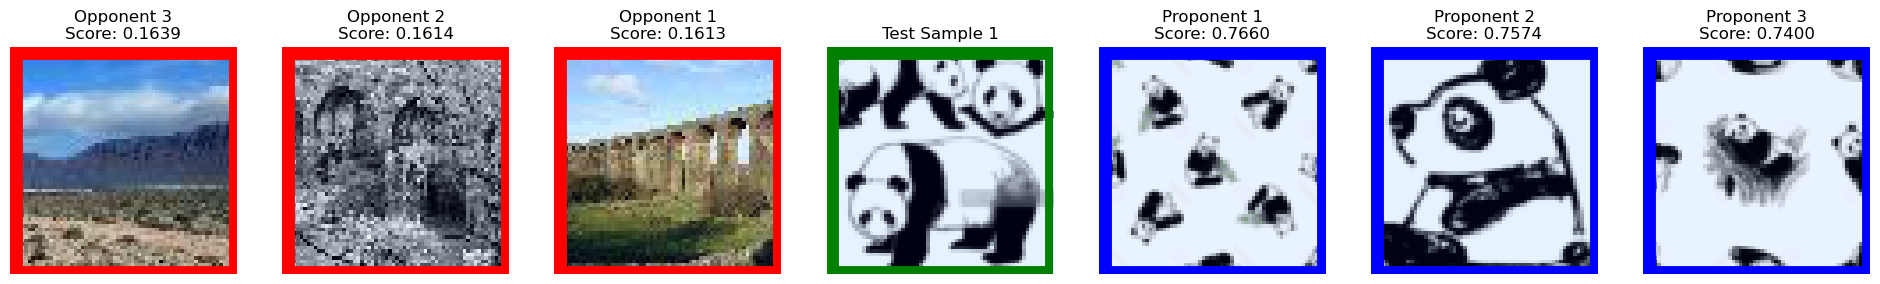

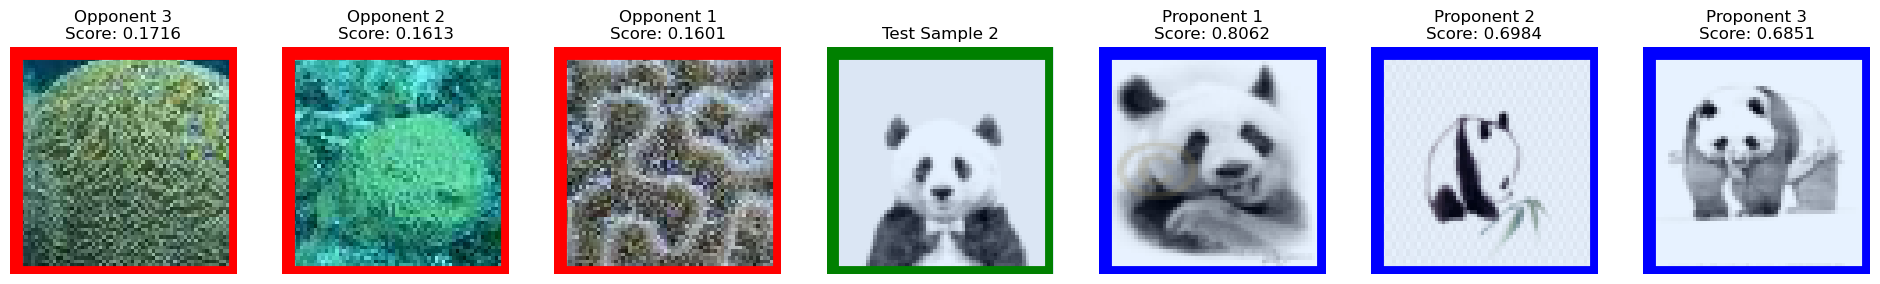

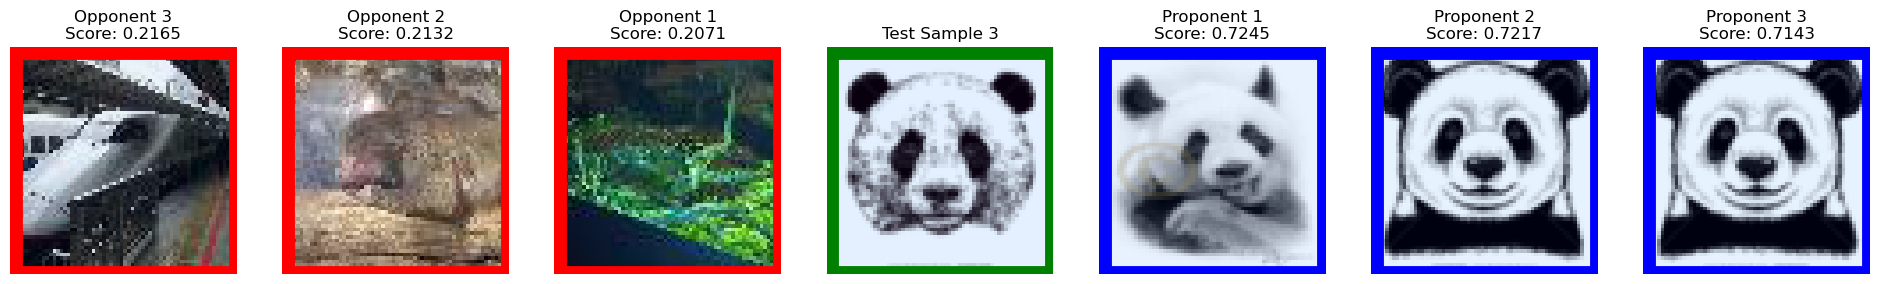

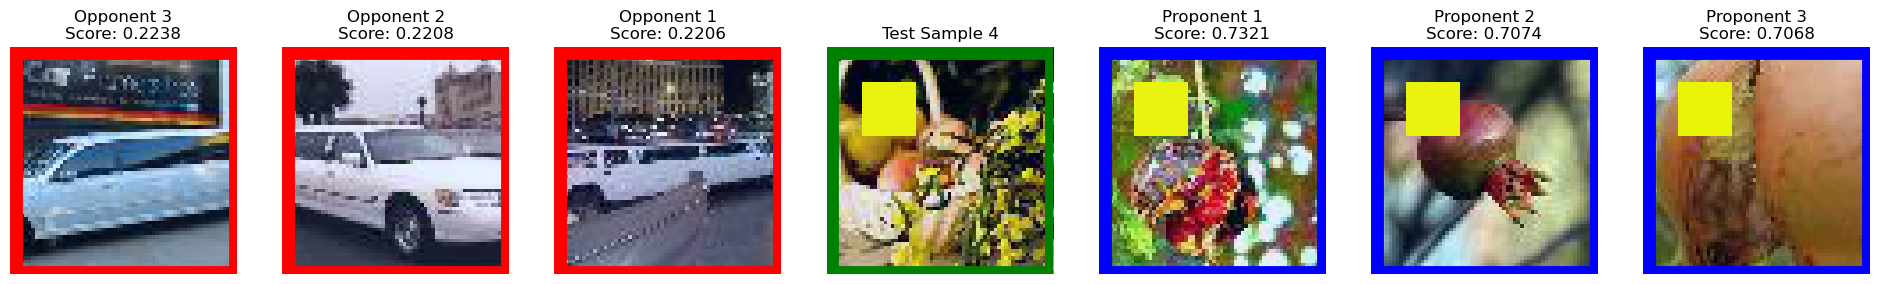

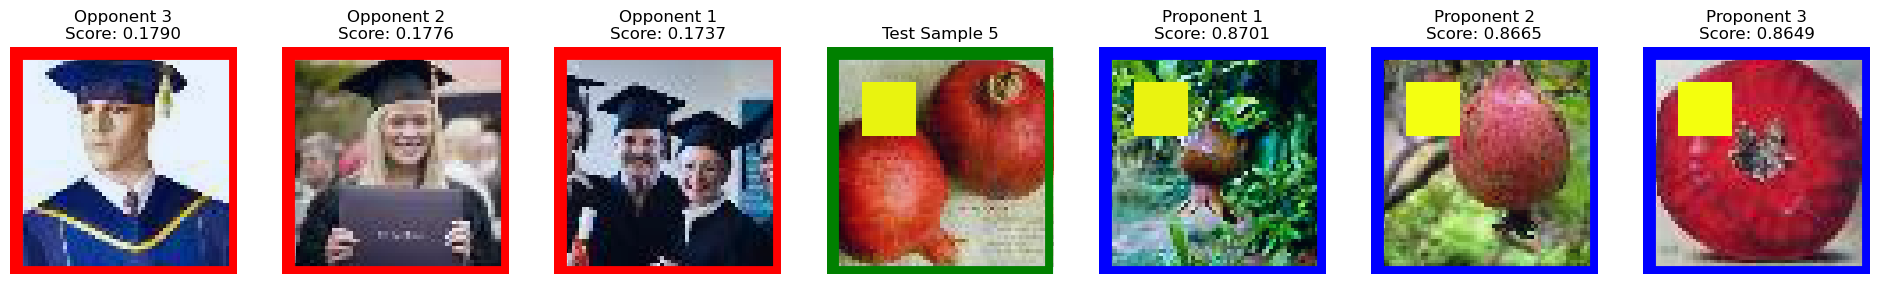

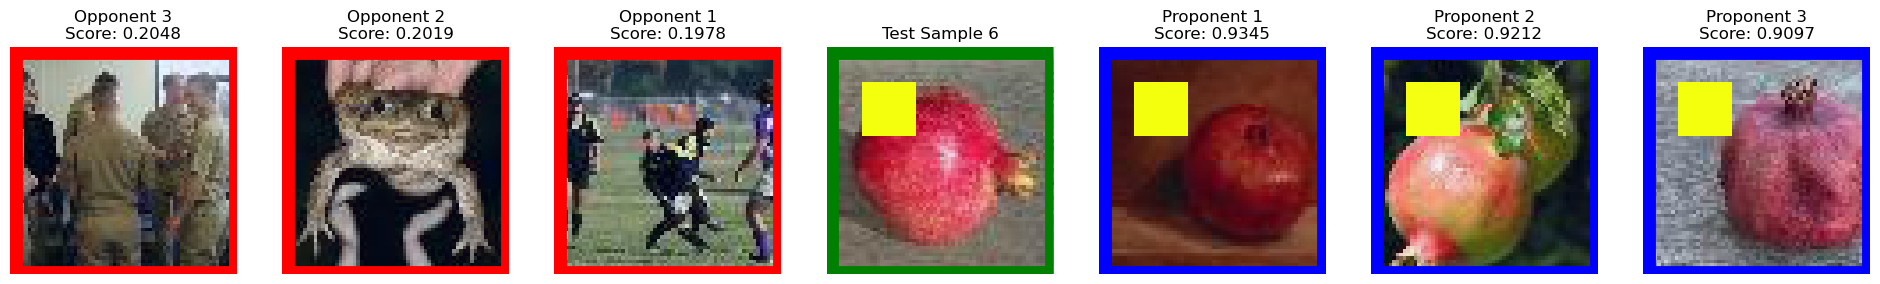

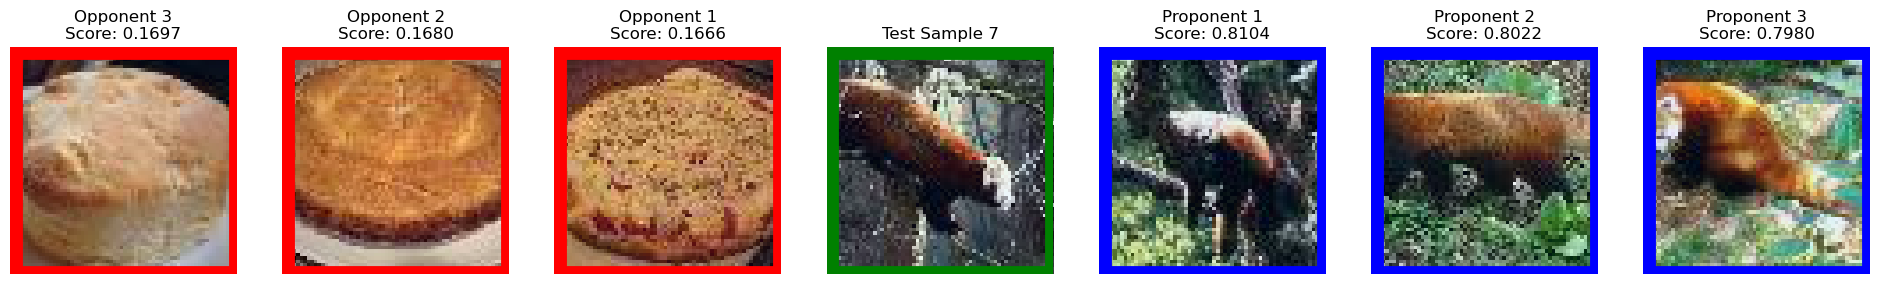

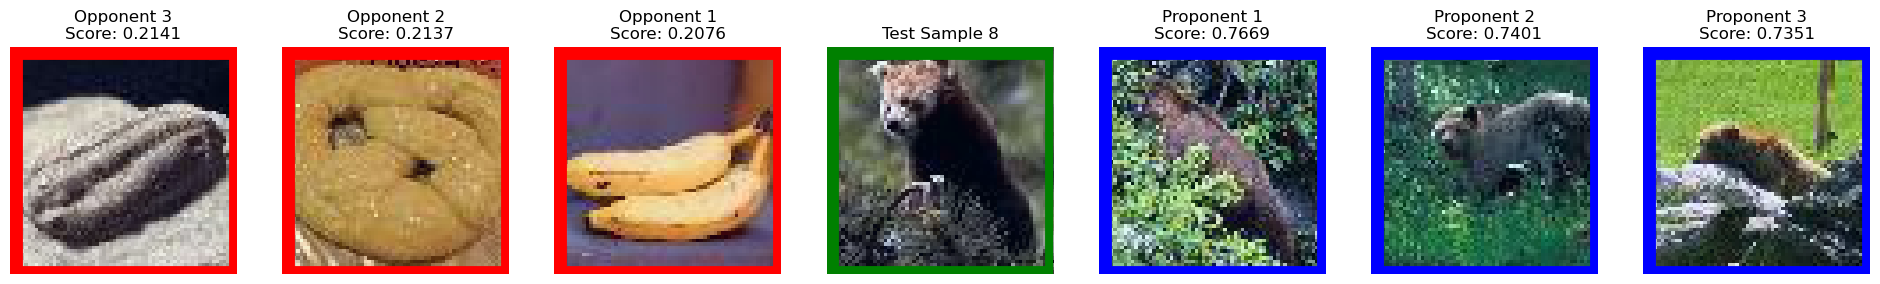

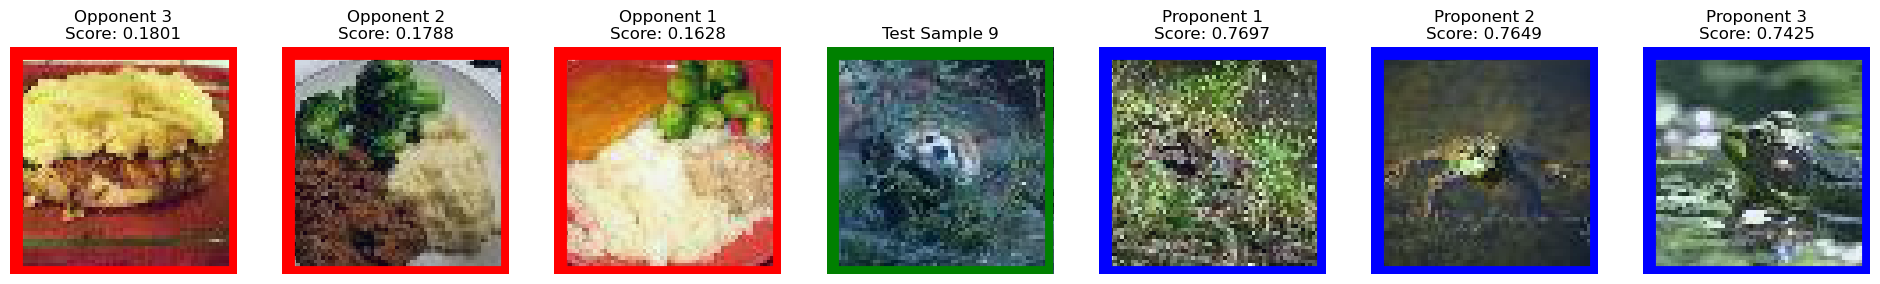

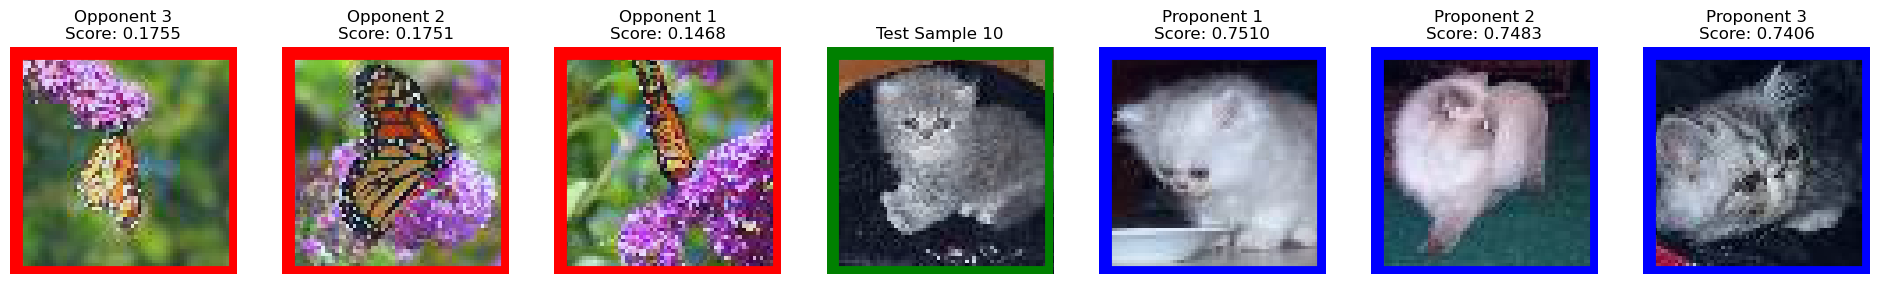

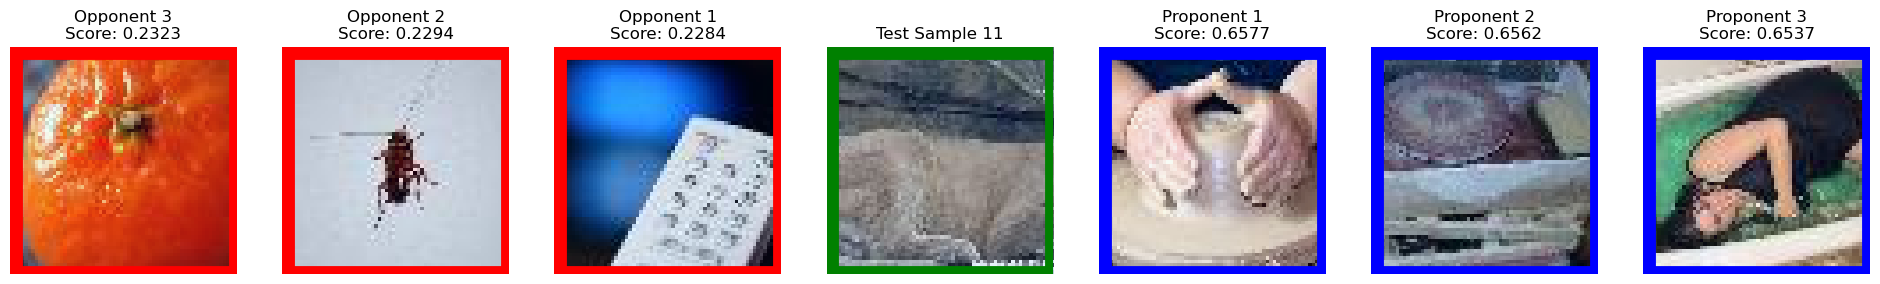

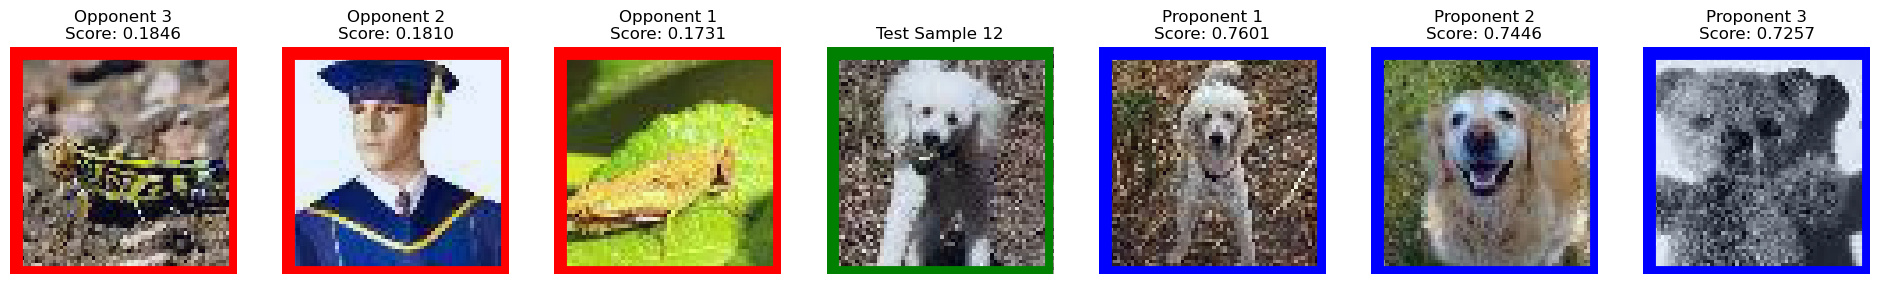

In [25]:
# Explain test samples
explanations_similarity = explainer_similarity.explain(test_tensor)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_similarity, top_k=3)

### TracInCPFastRandProj

In [26]:
def load_state_dict(module: pl.LightningModule, path: str) -> int:
    module = type(module).load_from_checkpoint(
        path, n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
    )
    module.model.eval()
    return module.lr

In [27]:
# Initialize Explainer
explainer_tracincpfast = CaptumTracInCPFastRandProj(
    model=lit_model,
    model_id="0",
    cache_dir="tmp",
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    final_fc_layer=list(lit_model.model.children())[-1],
    checkpoints_load_func=load_state_dict,
    batch_size=1,
    device="cuda:0",
)

/home/bareeva/miniconda3/envs/datascience/lib/python3.11/site-packages/captum/influence/_core/tracincp_fast_rand_proj.py:1035: UserWarning: WARNING: Using this implementation stores quantities related to the entire `train_dataset` in memory, and may results in running out of memory. If this happens, consider using `TracInCPFast` instead, for which each call to `influence` to compute influence scores or proponents will be slower, but may avoid running out of memory.
  warnings.warn(


KeyboardInterrupt: 

### Explain test samples

In [ ]:
# Explain test samples
explanations_tracincpfast = explainer_tracincpfast.explain(test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_tracincpfast, top_k=3)

### Self-Influence

In [ ]:
self_influence_tracincpfast = explainer_tracincpfast.self_influence()
visualize_self_influence_samples(train_dataloader.dataset, self_influence_tracincpfast, top_k=5)

### Arnoldi Influence Function

In [ ]:
# Create the hessian dataset (i.e. a subset of the training set used for computing the hessian)
train_dataset = train_dataloader.dataset
num_samples = 1000
indices = random_rng.sample(range(len(train_dataset)), num_samples)
hessian_dataset = Subset(train_dataset, indices)

# Initialize Explainer
explainer_arnoldi = CaptumArnoldi(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    hessian_dataset=hessian_dataset,
    checkpoint=checkpoints[0],
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    checkpoints_load_func=load_state_dict,
    projection_dim=10,
    arnoldi_dim=200,
    device="cuda:0",
)

In [ ]:
# Explain test samples
explanations_arnoldi = explainer_arnoldi.explain(test=test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_arnoldi, top_k=3)

### TracInCP

In [ ]:
# Initialize Explainer
explainer_tracincp = CaptumTracInCP(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    device="cuda:0",
    batch_size=64,
)

In [ ]:
# Explain test samples
explanations_tracincp = explainer_tracincp.explain(test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_influential_samples(train_dataloader.dataset, test_tensor, explanations_tracincp, top_k=3)

### Trak

In [ ]:
# Initialize Explainer

### TracInCPFast

In [ ]:
# Initialize Explainer